In [2]:
import torch
from PIL import Image
import torchvision 
torch.__version__
print(torch.cuda.current_device())


0


In [ ]:
cuda = torch.device('cuda')

'''
image_path = '/home/medathati/Work/SpectralSelfSupervision/Data/ILSVRC/Data/CLS-LOC/train/n03944341/n03944341_7353.JPEG'
img = Image.open(image_path).convert('RGB')
img1  = torchvision.transform(img)
'''


I  = torch.rand(5,3,5,5,device=cuda)
I_fft = torch.rfft(I, signal_ndim=2, onesided = False, normalized=False)
I_mag = ((I_fft[:,:,:,:,0]**2+I_fft[:,:,:,:,1]**2)**0.5)

I_mag_nth = I_mag**(1-0.1)
I_fft[:,:,:,:,0] = I_fft[:,:,:,:,0]/I_mag_nth
I_fft[:,:,:,:,1] = I_fft[:,:,:,:,1]/I_mag_nth
# batch x channels x height x width

I_fft[I_fft!=I_fft]=0
I_hat = torch.irfft(I_fft, signal_ndim=2, onesided = False, normalized=False)

print("Shape of input tensor: ",I.shape)
print("Shape of the FFT output: ",I_fft.shape)
print("Shape of the root filter output: ",I_hat.shape)

print(I)
print("---I_ht---")
print(I_hat)

In [ ]:
a = torch.tensor([0.0,1.5,2.0,3.0],device=cuda)
b = torch.tensor([0.0,.75,1.0,1.5],device=cuda)
c = b/a
c[c!=c]=0

print(a**2)
print(a**1)
print(b/a)
print(c)



In [ ]:
a.type()

In [ ]:
I  = torch.rand(3,3,device=cuda)
I1 = torch.min(I, dim=0,keepdim=True)
print(I)
print(I1)



In [ ]:
class MinMaxScalerVectorized(object):
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, tensor):
        """Fit features

        Parameters
        ----------
        stacked_features : tuple, list
            List of stacked features.

        Returns
        -------
        tensor 
            A tensor with scaled features using requested preprocessor.
        """

        tensor = torch.stack(tensor)

        # Feature range
        a, b = self.feature_range

        dist = tensor.max(dim=0, keepdim=True)[0] - tensor.min(dim=0, keepdim=True)[0]
        dist[dist == 0.0] = 1.0
        scale = 1.0 / dist
        tensor.mul_(scale).sub_(tensor.min(dim=0, keepdim=True)[0])
        tensor.mul_(b - a).add_(a)

        return tensor

scaler = MinMaxScalerVectorized(feature_range=(-1, 1))
I2 = scaler(I)
print(I2)

In [21]:
#a = torch.randn(3, 4, 16, 16, 16, 16)
a = torch.randn(3, 3,3)

def MinMaxNormalize(X):
    X_channel_flat = X.view(*(X.size()[:-2]),1,-1)
    X_channel_min,_ = torch.min(X_channel_flat,len(X.size())-1, keepdim=True, out=None)
    X_channel_max,_ = torch.max(X_channel_flat,len(X.size())-1, keepdim=True, out=None)
    X_channel_den = X_channel_max - X_channel_min
    X_channel_den[X_channel_den==0] = 1.0 # To avoid division by zero
    X_normalized_flat = (X_channel_flat - X_channel_min)/X_channel_den
    X_normalized = X_normalized_flat.view(X.size())
    return X_normalized

print(a)
print(MinMaxNormalize(a))


tensor([[[-0.0181,  1.4526, -0.6954],
         [-1.9581,  1.8875, -1.3373],
         [ 1.8075,  0.0487, -0.1688]],

        [[-1.1664,  0.3494,  0.6007],
         [ 2.9930,  0.8377,  1.1071],
         [-0.3170,  0.6347, -0.5970]],

        [[ 0.7540,  0.3548,  0.4827],
         [-1.1661,  0.6413, -0.2003],
         [ 1.1308, -1.1711,  0.6390]]])
tensor([[[0.5045, 0.8869, 0.3283],
         [0.0000, 1.0000, 0.1614],
         [0.9792, 0.5218, 0.4653]],

        [[0.0000, 0.3644, 0.4248],
         [1.0000, 0.4818, 0.5466],
         [0.2042, 0.4330, 0.1369]],

        [[0.8363, 0.6629, 0.7184],
         [0.0021, 0.7873, 0.4217],
         [1.0000, 0.0000, 0.7863]]])


In [5]:
n = 5
s = 0
d = 1.0/n
for i in range(n):
    s = s+d
    print(i,d, s)



0 0.2 0.2
1 0.2 0.4
2 0.2 0.6000000000000001
3 0.2 0.8
4 0.2 1.0


In [22]:
def root_filter(img,num_filters=2):
    assert(num_filters>1)
    img  = MinMaxNormalize(img)
    imgs = [img]
    #I = torch.from_numpy(img.transpose([2,0,1])).float().to('cuda')
    I_fft = torch.rfft(img, signal_ndim=2, onesided = False, normalized=False)
    I_mag = ((I_fft[:,:,:,:,0]**2+I_fft[:,:,:,:,1]**2)**0.5)
    #I_mag_nth = I_mag**(1-0.1)
    pf = 1.0/num_filters
    I_mag_nth = I_mag**(pf)
    for i in range(num_filters):
        I_fft[:,:,:,:,0] = I_fft[:,:,:,:,0]/I_mag_nth
        I_fft[:,:,:,:,1] = I_fft[:,:,:,:,1]/I_mag_nth
        I_fft[I_fft!=I_fft]=0
        I_hat = torch.irfft(I_fft, signal_ndim=2, onesided = False, normalized=False)
        I_hat_normalized = MinMaxNormalize(I_hat)
        imgs.append(I_hat_normalized)
    return imgs
cuda = torch.device('cuda')
img  = torch.rand(1,1,5,5,device=cuda)
imgs = root_filter(img,num_filters=2)
print(img)
print(imgs)
print(img.size())
print(len(imgs))

tensor([[[[0.3326, 0.5819, 0.0833, 0.8978, 0.9349],
          [0.7676, 0.2743, 0.0311, 0.1650, 0.4618],
          [0.4372, 0.4599, 0.6207, 0.8565, 0.2697],
          [0.6007, 0.2674, 0.1581, 0.0052, 0.9628],
          [0.3421, 0.9696, 0.0926, 0.8306, 0.4655]]]], device='cuda:0')
[tensor([[[[0.3326, 0.5819, 0.0833, 0.8978, 0.9349],
          [0.7676, 0.2743, 0.0311, 0.1650, 0.4618],
          [0.4372, 0.4599, 0.6207, 0.8565, 0.2697],
          [0.6007, 0.2674, 0.1581, 0.0052, 0.9628],
          [0.3421, 0.9696, 0.0926, 0.8306, 0.4655]]]], device='cuda:0'), tensor([[[[0.4075, 0.6396, 0.1400, 0.8936, 1.0000],
          [0.6735, 0.2278, 0.0432, 0.1771, 0.5463],
          [0.4833, 0.5341, 0.6430, 0.8265, 0.1866],
          [0.6182, 0.3581, 0.2392, 0.0000, 0.8495],
          [0.3790, 0.9552, 0.0652, 0.9895, 0.5886]]]], device='cuda:0'), tensor([[[[0.4290, 0.5534, 0.1646, 0.7898, 0.9564],
          [0.5045, 0.1638, 0.0486, 0.1581, 0.5523],
          [0.4378, 0.5477, 0.6037, 0.6451, 0.0400],
 

254.0


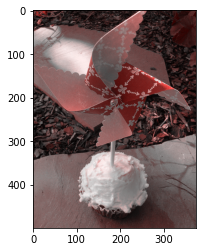

In [39]:
import numpy as np
import matplotlib.pylab as plt
image_path = '/home/medathati/Work/SpectralSelfSupervision/Data/ILSVRC/Data/CLS-LOC/train/n03944341/n03944341_7355.JPEG'
img = Image.open(image_path).convert('HSV')
na = np.array(img).astype(np.float)
print(np.max(na))
nb = np.array(na)

na[:,:,0] = 1
im = Image.fromarray(na.astype('uint8'), mode='HSV')

plt.figure()
plt.imshow(im)
plt.show()


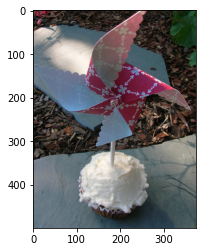

In [29]:
from matplotlib import pylab as plt
plt.figure()
plt.imshow(img)
plt.show()

In [33]:
a = np.array([365,379],dtype=np.uint8)

In [34]:
print(a)

[109 123]


In [35]:
365-109


256

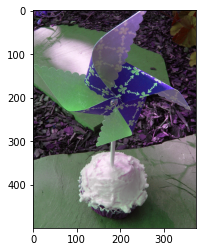

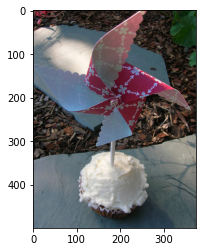

In [61]:
#import Image
import numpy as np
from PIL import Image

# Source: https://stackoverflow.com/questions/7274221/changing-image-hue-with-python-pil
def rgb_to_hsv(rgb):
    # Translated from source of colorsys.rgb_to_hsv
    # r,g,b should be a numpy arrays with values between 0 and 255
    # rgb_to_hsv returns an array of floats between 0.0 and 1.0.
    rgb = rgb.astype('float')
    hsv = np.zeros_like(rgb)
    # in case an RGBA array was passed, just copy the A channel
    hsv[..., 3:] = rgb[..., 3:]
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    maxc = np.max(rgb[..., :3], axis=-1)
    minc = np.min(rgb[..., :3], axis=-1)
    hsv[..., 2] = maxc
    mask = maxc != minc
    hsv[mask, 1] = (maxc - minc)[mask] / maxc[mask]
    rc = np.zeros_like(r)
    gc = np.zeros_like(g)
    bc = np.zeros_like(b)
    rc[mask] = (maxc - r)[mask] / (maxc - minc)[mask]
    gc[mask] = (maxc - g)[mask] / (maxc - minc)[mask]
    bc[mask] = (maxc - b)[mask] / (maxc - minc)[mask]
    hsv[..., 0] = np.select(
        [r == maxc, g == maxc], [bc - gc, 2.0 + rc - bc], default=4.0 + gc - rc)
    hsv[..., 0] = (hsv[..., 0] / 6.0) % 1.0
    return hsv

def hsv_to_rgb(hsv):
    # Translated from source of colorsys.hsv_to_rgb
    # h,s should be a numpy arrays with values between 0.0 and 1.0
    # v should be a numpy array with values between 0.0 and 255.0
    # hsv_to_rgb returns an array of uints between 0 and 255.
    rgb = np.empty_like(hsv)
    rgb[..., 3:] = hsv[..., 3:]
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = (h * 6.0).astype('uint8')
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6
    conditions = [s == 0.0, i == 1, i == 2, i == 3, i == 4, i == 5]
    rgb[..., 0] = np.select(conditions, [v, q, p, p, t, v], default=v)
    rgb[..., 1] = np.select(conditions, [v, v, v, q, p, p], default=t)
    rgb[..., 2] = np.select(conditions, [v, p, t, v, v, q], default=p)
    return rgb.astype('uint8')


def shift_hue(arr,hshift):
    hsv=rgb_to_hsv(arr)
    #hsv[...,0]=hshift #To set the hue
    hsv[...,0]= (hsv[...,0] + hshift)%1.0
    rgb=hsv_to_rgb(hsv)
    return rgb

#img = Image.open('tweeter.png').convert('RGBA')
#arr = np.array(img)

image_path = '/home/medathati/Work/SpectralSelfSupervision/Data/ILSVRC/Data/CLS-LOC/train/n03944341/n03944341_7355.JPEG'
img = Image.open(image_path).convert('RGB')
arr = np.array(img)

if __name__=='__main__':
    green_hue = (180-78)/360.0
    red_hue = (180-180)/360.0

    new_img = Image.fromarray(shift_hue(arr,270/360.0), 'RGB')
    new_img.save('tweeter_red.png')
    plt.figure()
    plt.imshow(new_img)
    plt.show()


    new_img = Image.fromarray(shift_hue(arr,0/360), 'RGB')
    new_img.save('tweeter_green.png')
    plt.figure()
    plt.imshow(new_img)
    plt.show()



In [55]:
a = np.array([1.5,0.5,0.25,0.5])
a  = a+0.5
print(a)
print(a%1.0)

[2.   1.   0.75 1.  ]
[0.   0.   0.75 0.  ]
